# Cross-Analysis Recap (Patched)

Notebook minimale per aggregare i risultati nelle cartelle `univ_ROI` utilizzando i nomi di file reali (`metrics_by_fold.csv`, `feature_importances_mean_std.csv`, ecc.).

**Istruzioni**:
1. Verifica sotto il percorso `results_root`.
2. Esegui la cella **Debug scanner** per controllare che gli esperimenti vengano rilevati.
3. Esegui la cella **Aggregazione standalone** per generare `experiments_summary.csv`, i grafici e `cross_analysis_recap.md`.

In [1]:
import os, re, csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# === Config ===
results_root = Path('/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI')
outdir = results_root / '_recap'
print('Results root:', results_root)
print('Output dir  :', outdir)

Results root: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI
Output dir  : /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap


## Debug scanner

In [2]:
EXPECTED_ANY = {
    'metric_scores.csv', 'fold_scores.csv', 'feature_importances_mean.csv',
    'predictions.csv', 'fold_predictions_long.csv',
    # nomi reali nei tuoi run
    'metrics_by_fold.csv', 'feature_importances_mean_std.csv', 'feature_importances_by_fold.csv',
}

csvs = list(results_root.rglob('*.csv'))
print(f'CSV totali trovati: {len(csvs)}')
for p in csvs[:15]:
    print('-', p)

experiments = set()
for p in csvs:
    name = p.name.lower()
    if (name in {n.lower() for n in EXPECTED_ANY}) or (name.startswith('best_fold_') and name.endswith('_feature_importances.csv')):
        experiments.add(p.parent)
experiments = sorted(experiments)
print(f'\nCartelle esperimento trovate: {len(experiments)}')
for d in experiments[:20]:
    print('-', d)

CSV totali trovati: 71
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_effectiveness/metrics_by_fold.csv
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_effectiveness/best_fold_2_feature_importances.csv
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_effectiveness/feature_importances_by_fold.csv
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_effectiveness/feature_importances_mean_std.csv
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_barthel/metrics_by_fold.csv
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_barthel/best_fold_5_feature_importances.csv
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_offset_barthel/feature_importances_

## Aggregazione standalone

Esperimenti trovati: 18
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_delta_barthel
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_delta_effectiveness
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_delta_fim
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_exponent_barthel
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_exponent_effectiveness
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_exponent_fim
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_higuci_barthel
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_higuci_effectiveness
- /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/univ_higuci

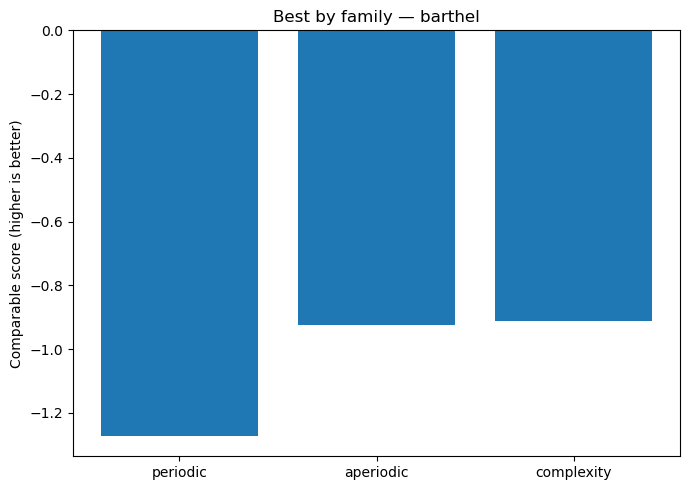

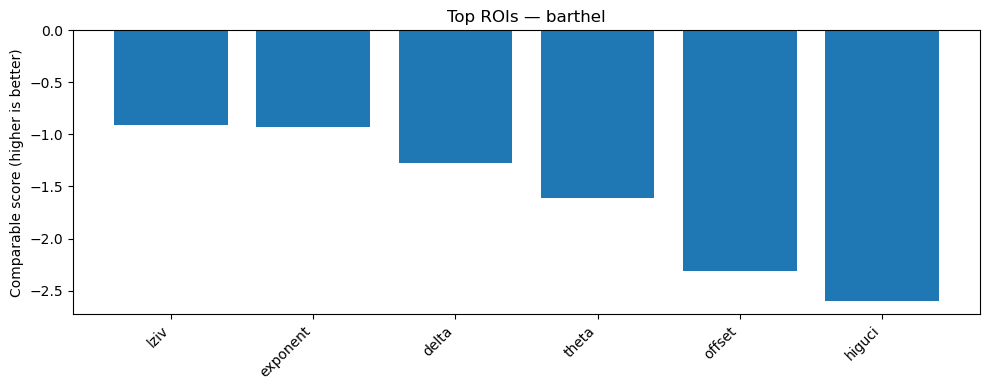

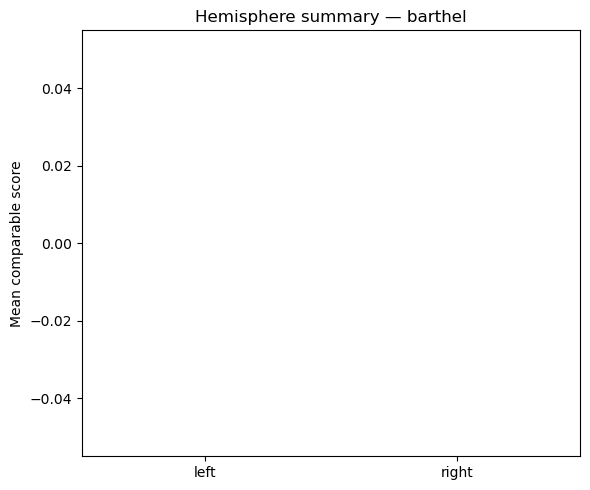

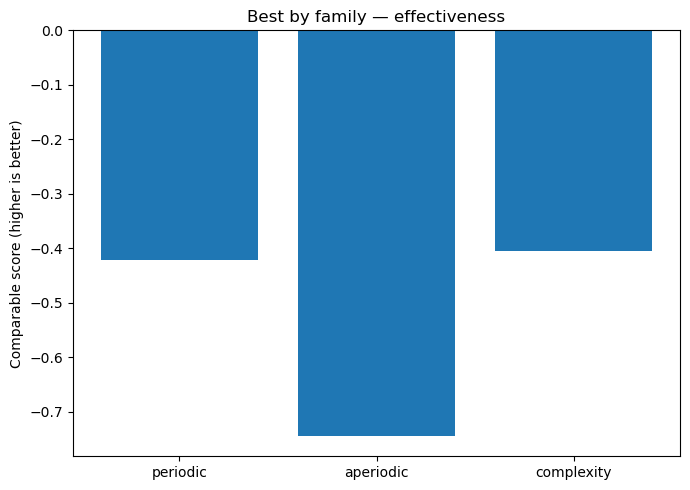

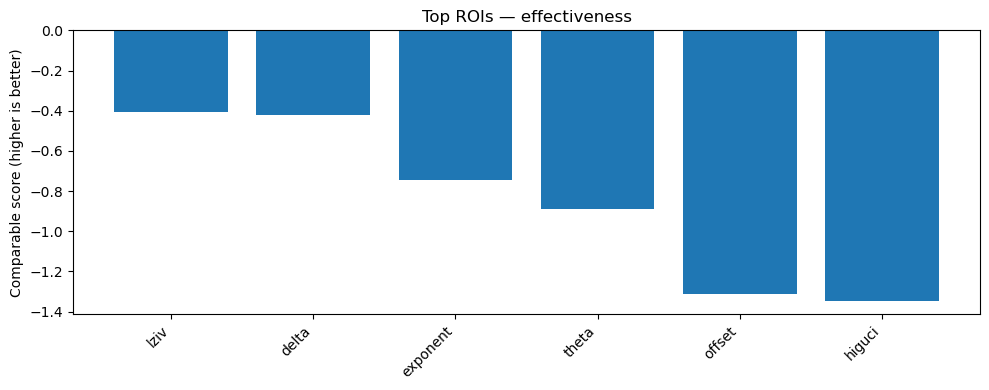

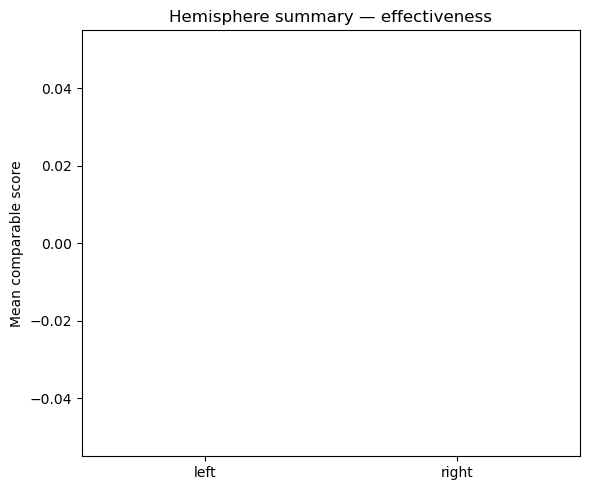

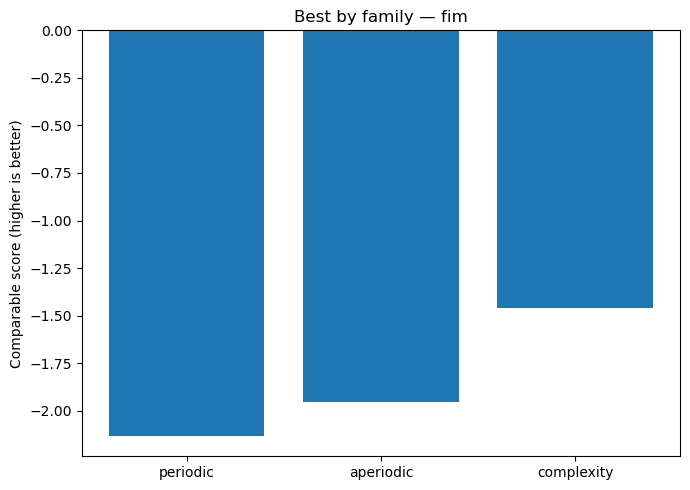

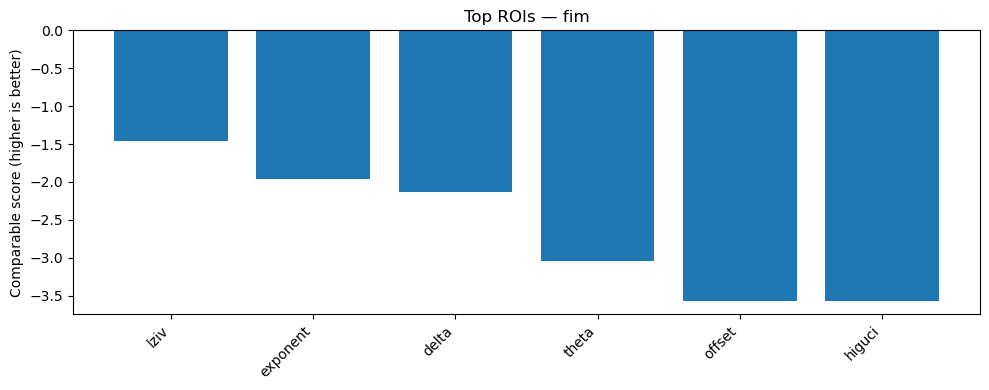

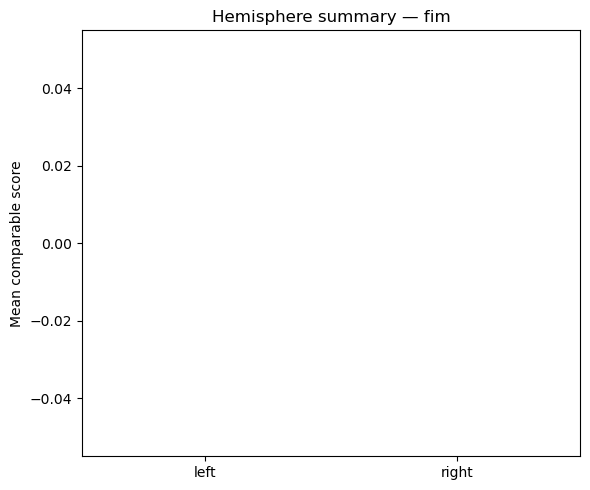

Report scritto in: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/cross_analysis_recap.md


In [4]:
import csv, re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

outdir.mkdir(parents=True, exist_ok=True)

def read_csv_rows(path: Path):
    if not path.exists():
        return []
    with open(path, 'r', encoding='utf-8') as f:
        return list(csv.DictReader(f))

def safe_float(x, default=np.nan):
    try: return float(x)
    except: return default

def infer_target_from_path(p: Path) -> str:
    s = p.as_posix().lower()
    if 'barthel' in s: return 'barthel'
    if 'fim' in s: return 'fim'
    if 'effectiveness' in s: return 'effectiveness'
    return 'unknown'

def infer_family_from_path(p: Path) -> str:
    s = p.name.lower()
    if any(k in s for k in ['delta','theta']): return 'periodic'
    if any(k in s for k in ['exponent','offset']): return 'aperiodic'
    if any(k in s for k in ['lziv','higuci','higuchi']): return 'complexity'
    return 'other'

def infer_feature_key_from_path(p: Path) -> str:
    s = p.name.lower()
    for k in ['delta','theta','exponent','offset','lziv','higuci','higuchi']:
        if k in s: return k
    return 'unknown'

def infer_roi_from_importances(imp_rows):
    if not imp_rows: return ''
    feats = [r.get('feature','') for r in imp_rows if r.get('feature')]
    text = '_'.join(feats).lower()
    rois = ['frontal','temporal','parietal','occipital','central','cingulate','hippocampus','insula']
    sides = ['left','right','l','r']
    found_roi = next((roi for roi in rois if roi in text), None)
    found_side = None
    for s in sides:
        if re.search(rf'(^|[_\-]){s}([_\-]|$)', text):
            found_side = s; break
    if found_roi and found_side: return f'{found_roi}_{found_side}'
    return found_roi or ''

def choose_score_for_comparison(metric_name, value, direction):
    if value is None or np.isnan(value): return np.nan
    return -value if direction=='lower_is_better' else value

def coerce_metric_rows_from_metrics_by_fold(exp_dir: Path):
    rows = read_csv_rows(exp_dir / 'metrics_by_fold.csv')
    if not rows: return []
    keys = {k.lower(): k for k in rows[0].keys()}
    candidates = ['r2','rmse','mae','mse','accuracy','f1','mape']
    out = []
    for m in candidates:
        k = keys.get(m)
        if not k: continue
        vals = [safe_float(r.get(k)) for r in rows]
        vals = [v for v in vals if np.isfinite(v)]
        if vals:
            out.append({'metric': m, 'value': float(np.mean(vals))})
    return out

def coerce_imp_rows_from_mean_std(exp_dir: Path):
    rows = read_csv_rows(exp_dir / 'feature_importances_mean_std.csv')
    if not rows: return []
    keys = {k.lower(): k for k in rows[0].keys()}
    c_feat = keys.get('feature') or keys.get('features') or keys.get('name')
    c_mean = keys.get('mean_importance') or keys.get('mean') or keys.get('avg')
    c_std  = keys.get('std_importance')  or keys.get('std')  or keys.get('sd')
    out = []
    for r in rows:
        feat = r.get(c_feat, '') if c_feat else ''
        mi = safe_float(r.get(c_mean)) if c_mean else np.nan
        sd = safe_float(r.get(c_std)) if c_std else np.nan
        if feat:
            out.append({'feature': feat, 'mean_importance': mi, 'std_importance': sd})
    return out

def best_metric_from_rows(metric_rows):
    m = { (r.get('metric') or '').lower(): safe_float(r.get('value')) for r in metric_rows }
    if 'r2' in m:      return ('r2', m['r2'], 'higher_is_better')
    if 'rmse' in m:    return ('rmse', m['rmse'], 'lower_is_better')
    if 'mae' in m:     return ('mae', m['mae'], 'lower_is_better')
    if 'accuracy' in m:return ('accuracy', m['accuracy'], 'higher_is_better')
    if 'f1' in m:      return ('f1', m['f1'], 'higher_is_better')
    return ('', np.nan, 'higher_is_better')

EXPECTED_ANY = {'metrics_by_fold.csv','feature_importances_mean_std.csv','feature_importances_by_fold.csv',
                'metric_scores.csv','fold_scores.csv','feature_importances_mean.csv','predictions.csv','fold_predictions_long.csv'}
experiments = sorted({
    p.parent for p in results_root.rglob('*.csv')
    if (p.name.lower() in {n.lower() for n in EXPECTED_ANY}) or (p.name.lower().startswith('best_fold_') and p.name.lower().endswith('_feature_importances.csv'))
})
print('Esperimenti trovati:', len(experiments))
for d in experiments[:10]:
    print('-', d)

summaries = []
for exp in experiments:
    metric_rows = coerce_metric_rows_from_metrics_by_fold(exp)
    imp_rows = coerce_imp_rows_from_mean_std(exp)

    target = infer_target_from_path(exp)
    family = infer_family_from_path(exp)
    feature_key = infer_feature_key_from_path(exp)
    roi_guess = infer_roi_from_importances(imp_rows)

    metric_name, metric_value, direction = best_metric_from_rows(metric_rows)
    score_for_compare = choose_score_for_comparison(metric_name, metric_value, direction) if metric_name else np.nan

    top_feature = ''; top_mean_imp = np.nan; top_std_imp = np.nan
    if imp_rows:
        imp_sorted = sorted(imp_rows, key=lambda r: r['mean_importance'] if np.isfinite(r['mean_importance']) else -1, reverse=True)
        if imp_sorted:
            top_feature = imp_sorted[0]['feature']
            top_mean_imp = imp_sorted[0]['mean_importance']
            top_std_imp = imp_sorted[0]['std_importance']

    summaries.append({
        'exp_dir': exp.as_posix(),
        'target': target,
        'family': family,
        'feature_key': feature_key,
        'roi_guess': roi_guess or '',
        'metric_name': metric_name,
        'metric_value': metric_value,
        'metric_direction': direction,
        'score_for_compare': score_for_compare,
        'top_feature': top_feature,
        'top_feature_mean_imp': top_mean_imp,
        'top_feature_std_imp': top_std_imp,
    })

def write_csv_rows(path: Path, rows, fieldnames=None):
    if not rows: return
    if fieldnames is None:
        fieldnames = list(rows[0].keys())
        extra = set().union(*[set(r.keys()) for r in rows]) - set(fieldnames)
        fieldnames += sorted(extra)
    with open(path, 'w', newline='', encoding='utf-8') as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        for r in rows:
            w.writerow(r)

write_csv_rows(outdir / 'experiments_summary.csv', summaries)
print('Salvato:', outdir / 'experiments_summary.csv')

def plot_best_by_family(summaries, target, outdir):
    rows = [s for s in summaries if s['target']==target and np.isfinite(s['score_for_compare'])]
    if not rows:
        print('[skip] best_by_family', target)
        return
    best = {}
    for r in rows:
        fam = r['family']
        if fam not in best or r['score_for_compare'] > best[fam]['score_for_compare']:
            best[fam] = r
    labels = list(best.keys())
    vals = [best[k]['score_for_compare'] for k in labels]
    plt.figure(figsize=(7,5))
    x = np.arange(len(labels))
    plt.bar(x, vals)
    plt.xticks(x, labels)
    plt.ylabel('Comparable score (higher is better)')
    plt.title(f'Best by family — {target}')
    plt.tight_layout()
    plt.savefig(outdir / f'best_by_family_{target}.png', dpi=150)
    plt.show()

def plot_top_rois(summaries, target, outdir, top_k=12):
    rows = [s for s in summaries if s['target']==target and np.isfinite(s['score_for_compare'])]
    if not rows:
        print('[skip] top_rois', target)
        return
    best_by_roi = {}
    for r in rows:
        roi = r['roi_guess'] or r['feature_key']
        if roi not in best_by_roi or r['score_for_compare'] > best_by_roi[roi]['score_for_compare']:
            best_by_roi[roi] = r
    items = sorted(best_by_roi.items(), key=lambda kv: kv[1]['score_for_compare'], reverse=True)[:top_k]
    labels = [k for k,_ in items]
    vals = [v['score_for_compare'] for _, v in items]
    plt.figure(figsize=(10, max(4, 0.5*len(labels))))
    x = np.arange(len(labels))
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Comparable score (higher is better)')
    plt.title(f'Top ROIs — {target}')
    plt.tight_layout()
    plt.savefig(outdir / f'top_rois_{target}.png', dpi=150)
    plt.show()

def hemisphere_from_label(label: str):
    s = (label or '').lower().split('_')
    if 'right' in s or 'r' in s: return 'right'
    if 'left' in s or 'l' in s: return 'left'
    return None

def plot_hemisphere_summary(summaries, target, outdir):
    rows = [s for s in summaries if s['target']==target and np.isfinite(s['score_for_compare'])]
    if not rows:
        print('[skip] hemisphere', target)
        return
    left = []; right = []
    for r in rows:
        hemi = hemisphere_from_label(r.get('roi_guess',''))
        if hemi == 'left': left.append(r['score_for_compare'])
        elif hemi == 'right': right.append(r['score_for_compare'])
    labels = ['left','right']
    vals = [float(np.nanmean(left)) if left else 0.0,
            float(np.nanmean(right)) if right else 0.0]
    plt.figure(figsize=(6,5))
    x = np.arange(len(labels))
    plt.bar(x, vals)
    plt.xticks(x, labels)
    plt.ylabel('Mean comparable score')
    plt.title(f'Hemisphere summary — {target}')
    plt.tight_layout()
    plt.savefig(outdir / f'hemisphere_summary_{target}.png', dpi=150)
    plt.show()

targets = sorted(set(s['target'] for s in summaries))
for t in targets:
    plot_best_by_family(summaries, t, outdir)
    plot_top_rois(summaries, t, outdir)
    plot_hemisphere_summary(summaries, t, outdir)

md = []
md.append('# Cross-analysis Recap\n')
md.append('Confronto tra **periodic (delta/theta)**, **aperiodic (exponent/offset)** e **complexity (lziv/higuci)** sui target (Barthel, FIM, Effectiveness).')
md.append('Gli score sono resi comparabili come *higher is better* (MAE/RMSE negati).\n')
for t in targets:
    rows_t = [s for s in summaries if s['target']==t and np.isfinite(s['score_for_compare'])]
    md.append(f'## Target: {t}\n')
    if not rows_t:
        md.append('_Nessun esperimento valido._\n')
        continue
    by_fam = {}
    for r in rows_t:
        fam = r['family']
        if fam not in by_fam or r['score_for_compare'] > by_fam[fam]['score_for_compare']:
            by_fam[fam] = r
    md.append('**Best by family**:\n')
    for fam, r in by_fam.items():
        md.append(f"- {fam}: `{r['metric_name']}={r['metric_value']:.4f}` @ ROI `{r['roi_guess'] or r['feature_key']}` (dir={r['metric_direction']})")
    md.append('')
    best_by_roi = {}
    for r in rows_t:
        roi = r['roi_guess'] or r['feature_key']
        if roi not in best_by_roi or r['score_for_compare'] > best_by_roi[roi]['score_for_compare']:
            best_by_roi[roi] = r
    top5 = sorted(best_by_roi.items(), key=lambda kv: kv[1]['score_for_compare'], reverse=True)[:5]
    md.append('**Top ROIs overall**:\n')
    for i,(roi, rr) in enumerate(top5, 1):
        md.append(f"{i}. `{roi}` — {rr['metric_name']}={rr['metric_value']:.4f} ({rr['family']})")
    md.append('')
    md.append(f'![Best by family — {t}](best_by_family_{t}.png)\n')
    md.append(f'![Top ROIs — {t}](top_rois_{t}.png)\n')
    md.append(f'![Hemisphere summary — {t}](hemisphere_summary_{t}.png)\n')

report_path = outdir / 'cross_analysis_recap.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(md))
print('Report scritto in:', report_path)


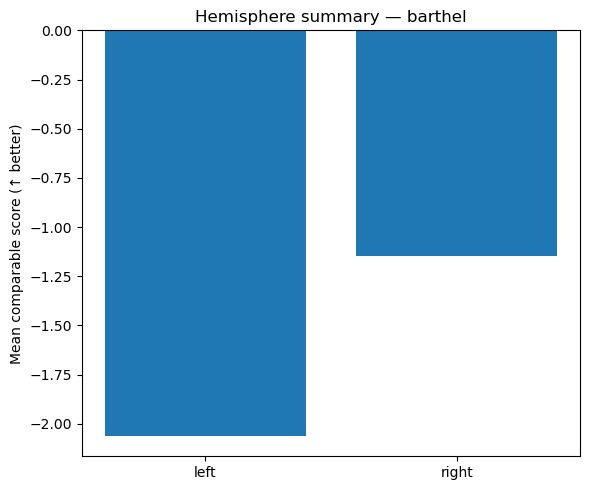

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/hemisphere_summary_barthel.png


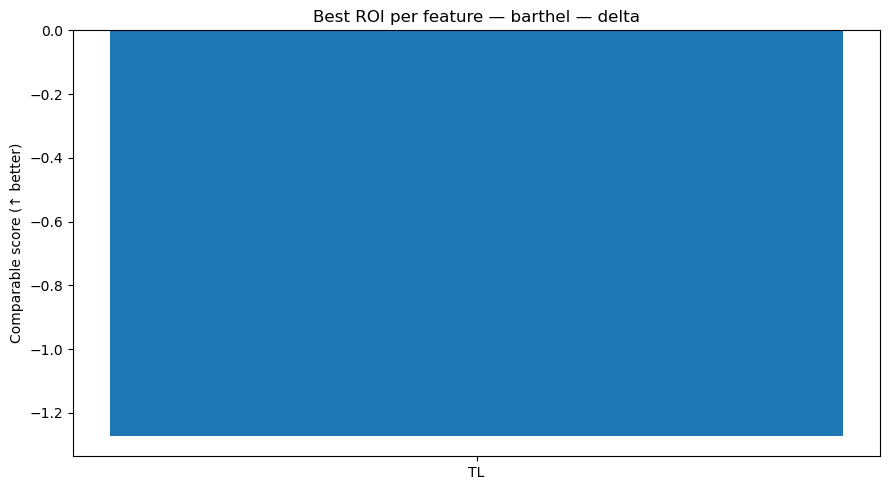

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_barthel_delta.png


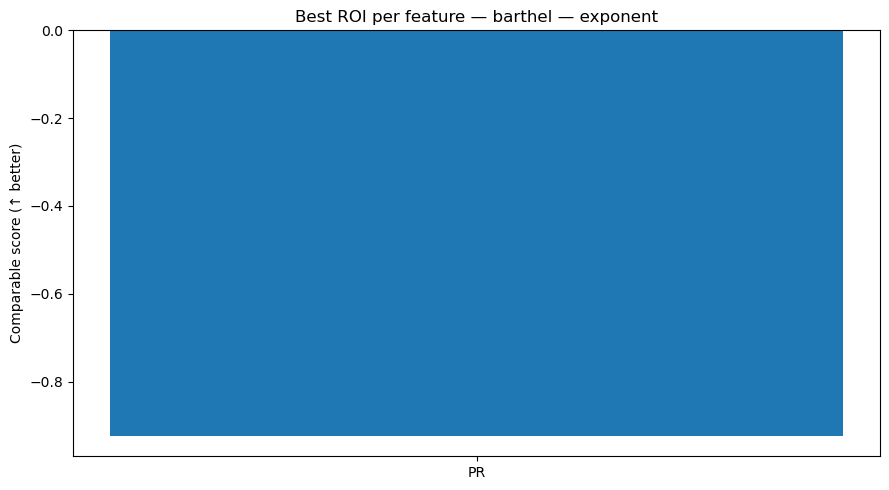

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_barthel_exponent.png


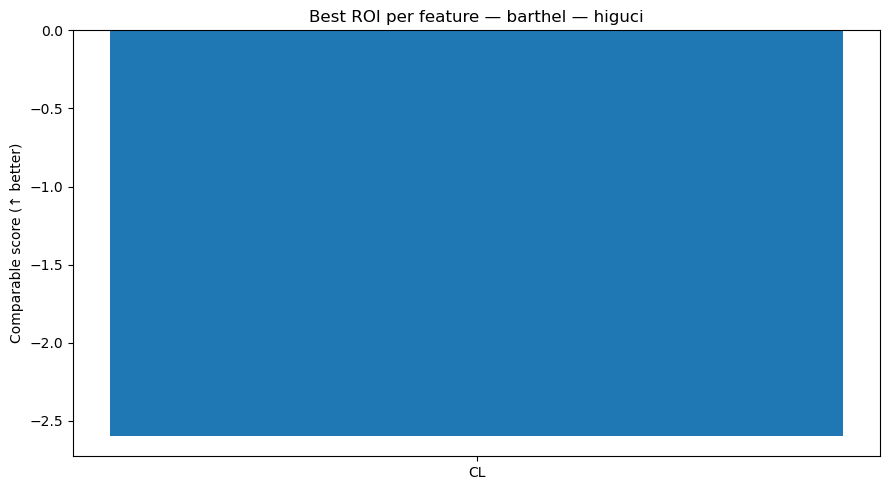

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_barthel_higuci.png


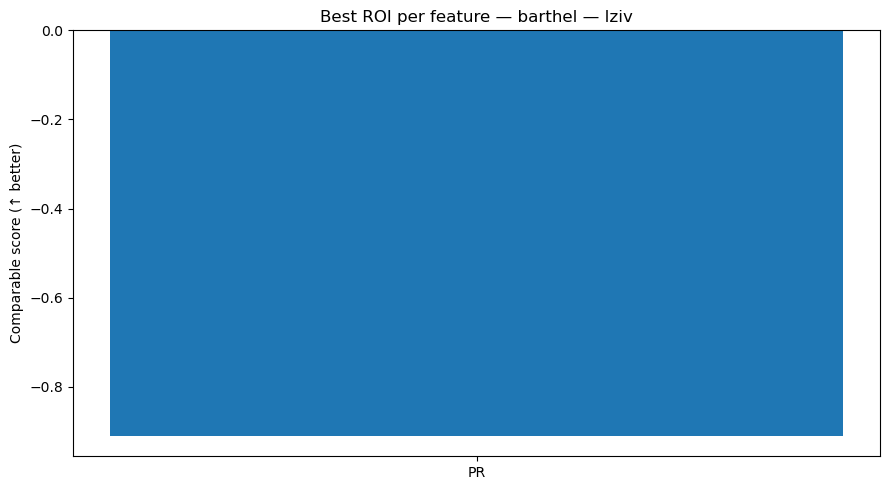

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_barthel_lziv.png


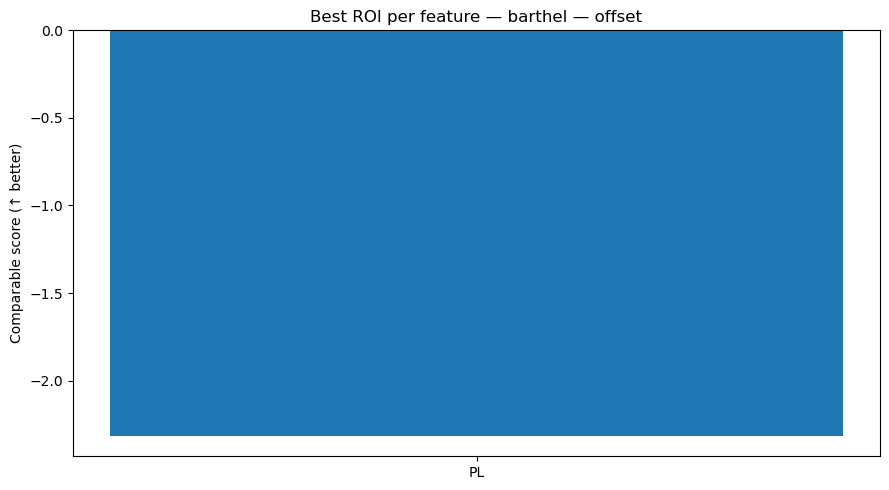

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_barthel_offset.png


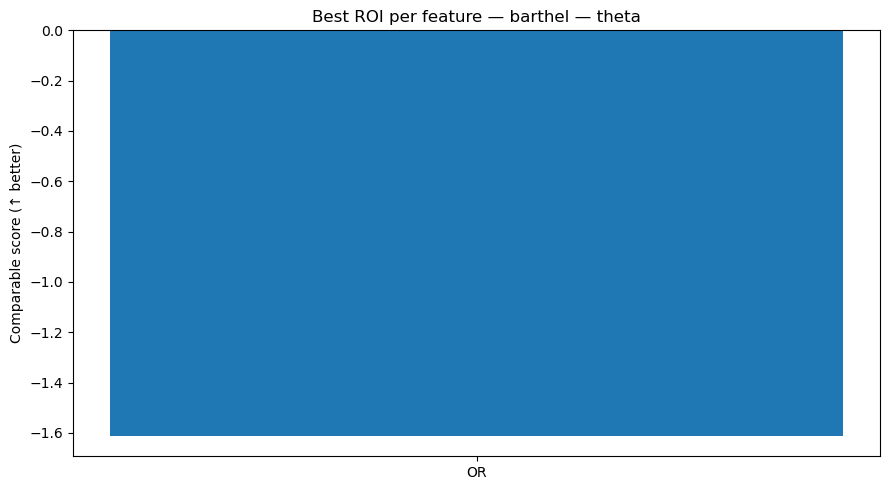

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_barthel_theta.png


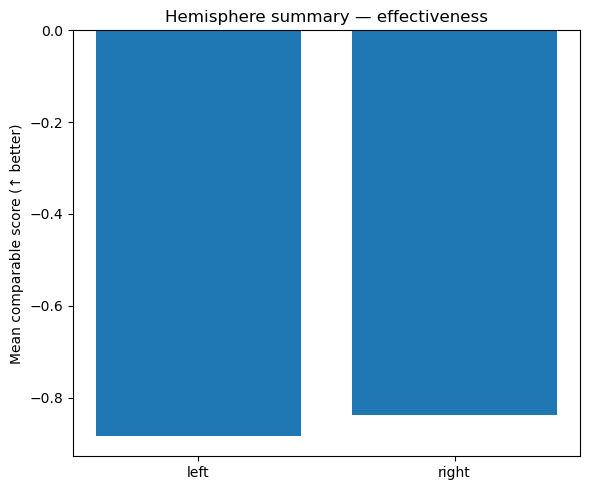

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/hemisphere_summary_effectiveness.png


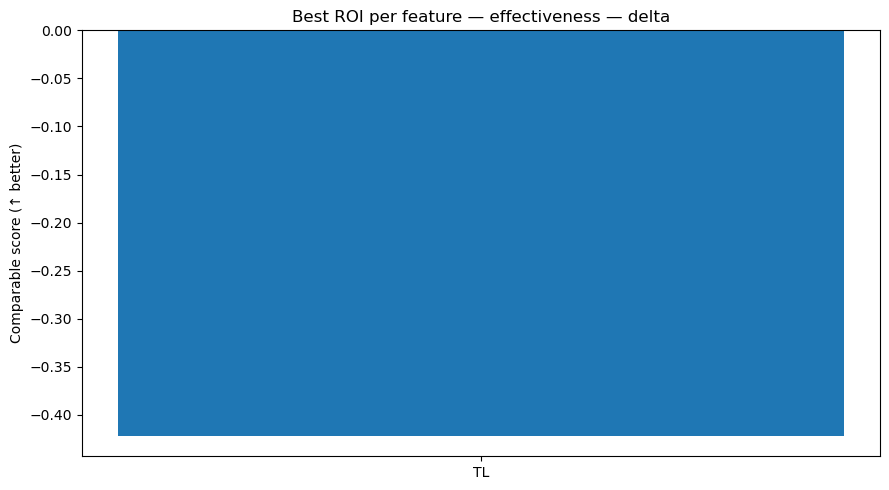

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_effectiveness_delta.png


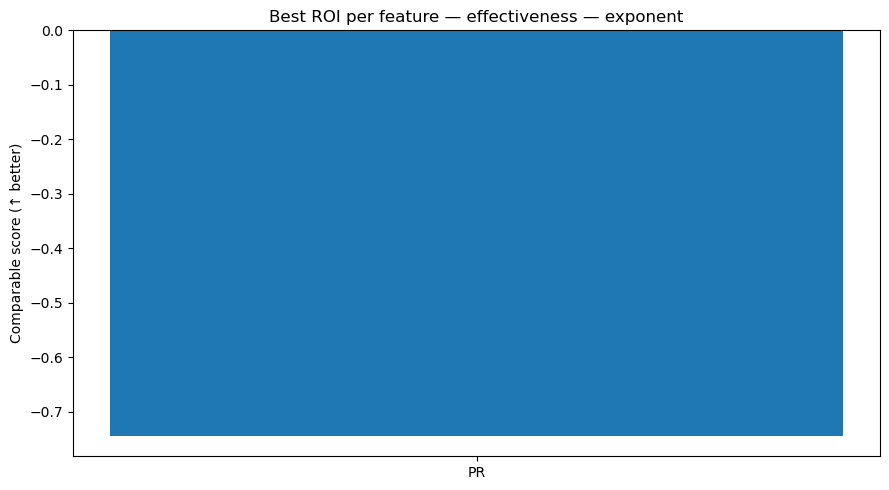

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_effectiveness_exponent.png


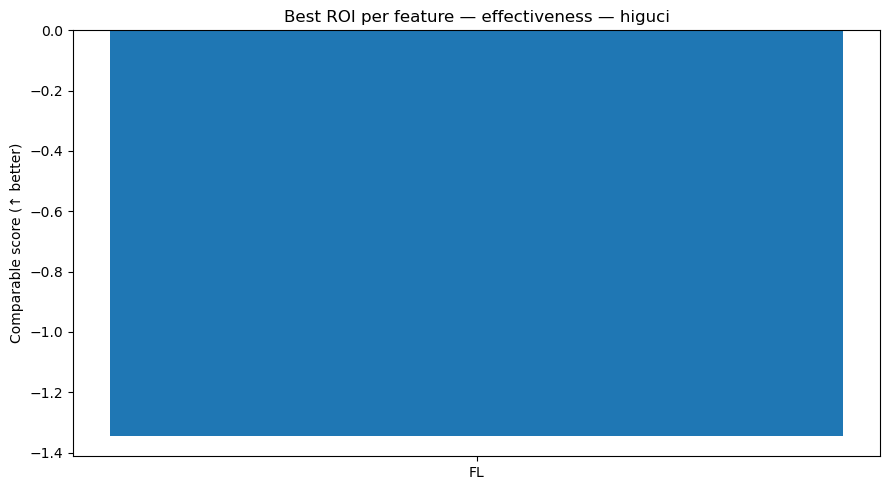

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_effectiveness_higuci.png


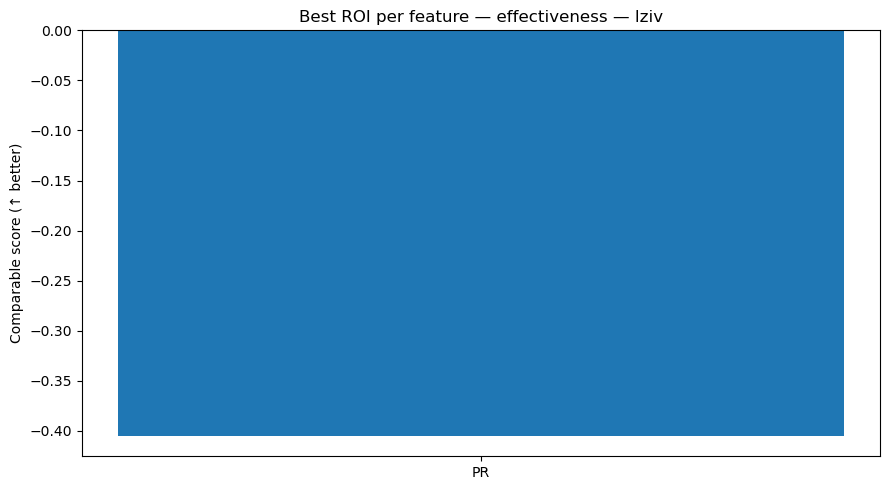

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_effectiveness_lziv.png


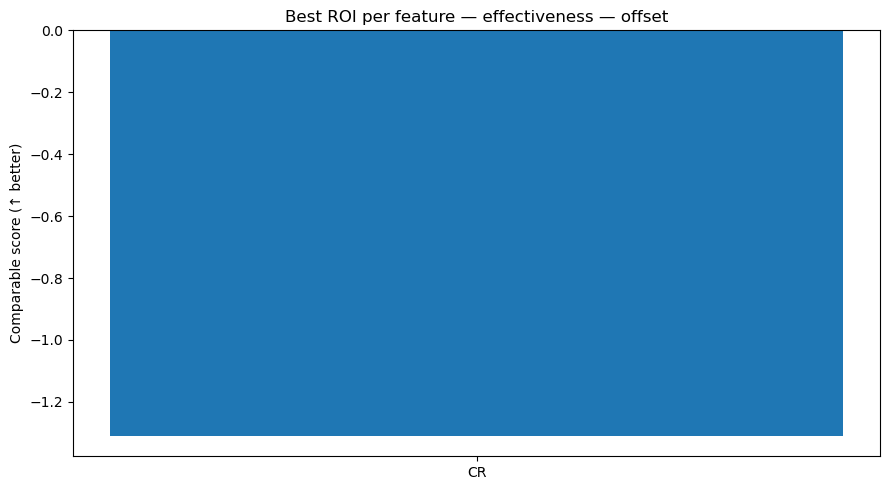

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_effectiveness_offset.png


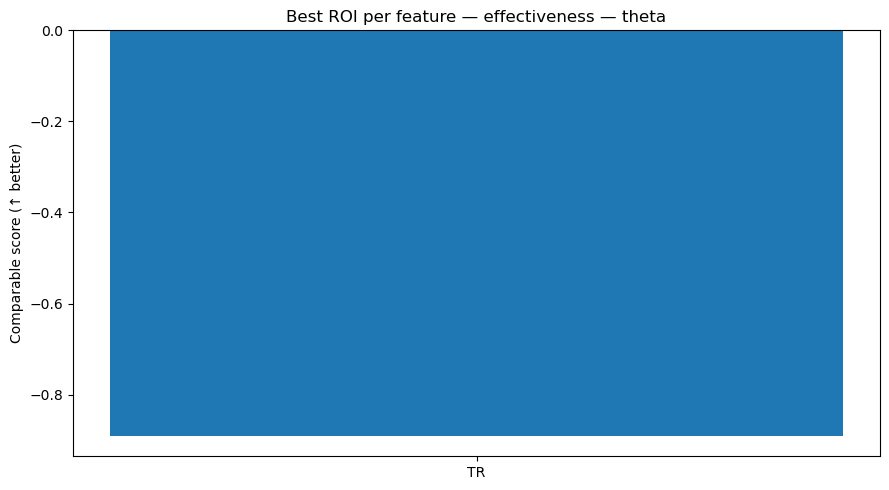

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_effectiveness_theta.png


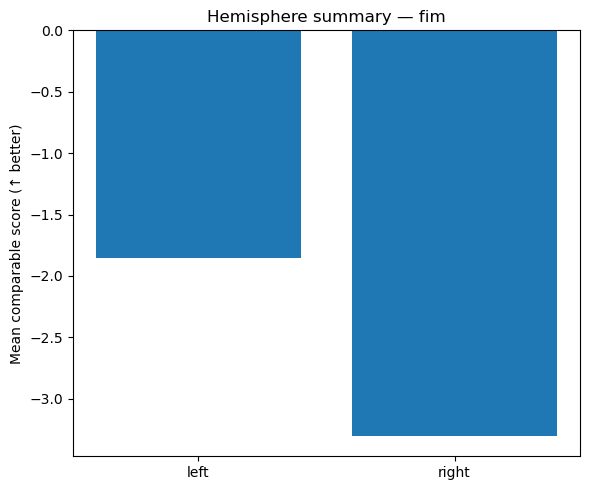

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/hemisphere_summary_fim.png


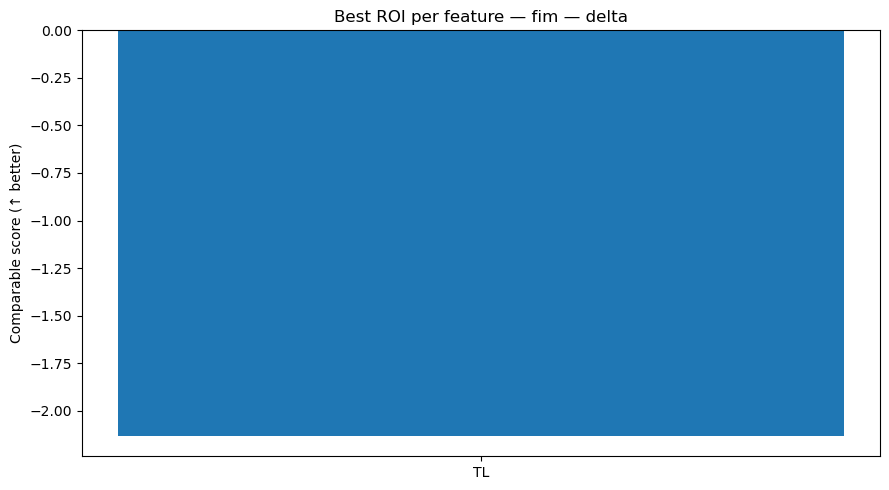

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_fim_delta.png


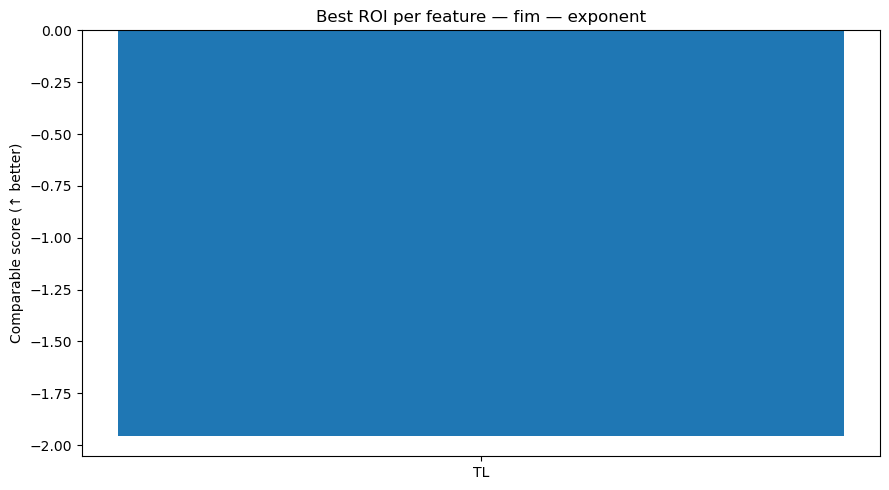

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_fim_exponent.png


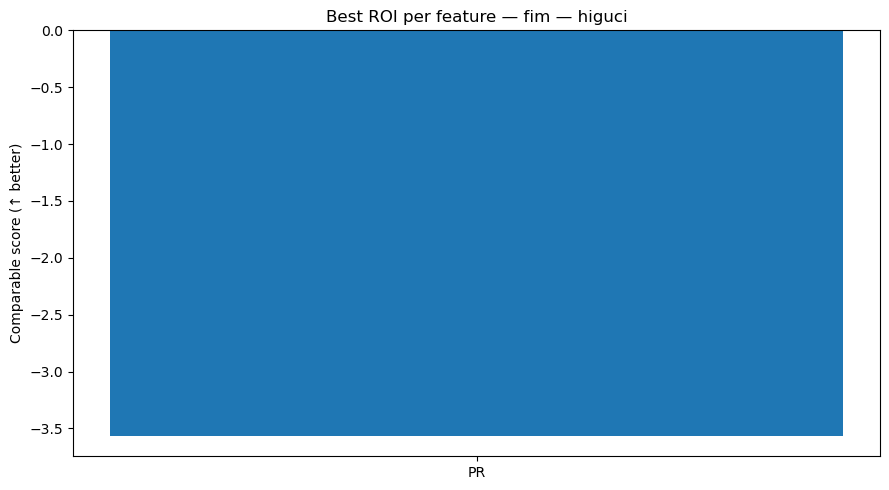

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_fim_higuci.png


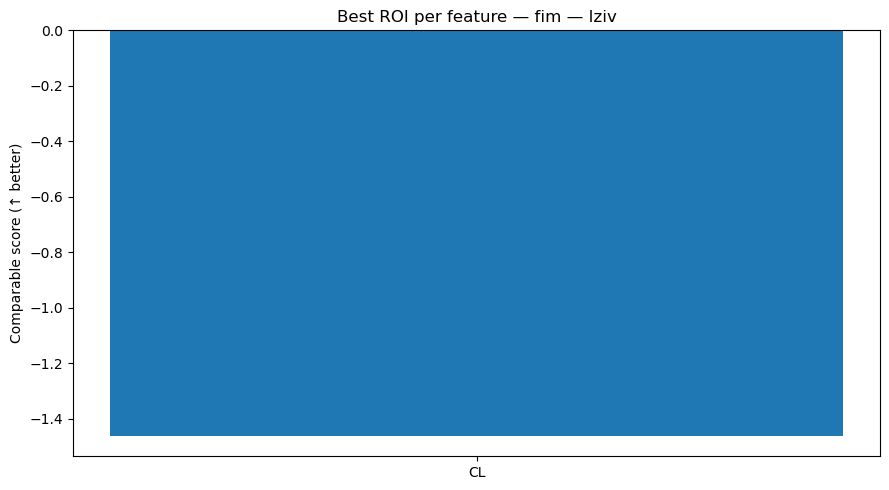

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_fim_lziv.png


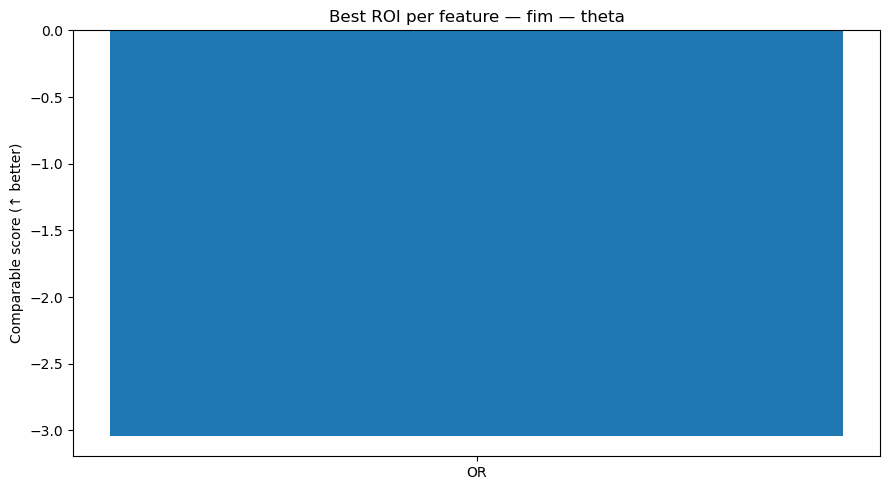

Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_ROI/_recap/best_roi_per_feature_fim_theta.png


In [5]:
# === PATCH ROI & GRAFICI PER FEATURE ===
import re, csv, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# 1) Mappatura ROI compatte e parser
ROI_CODE_MAP = {
    'FL':'frontal_left','FR':'frontal_right',
    'CL':'central_left','CR':'central_right',
    'TL':'temporal_left','TR':'temporal_right',
    'PL':'parietal_left','PR':'parietal_right',
    'OL':'occipital_left','OR':'occipital_right',
}
ROI_LONG_TO_CODE = {v:k for k,v in ROI_CODE_MAP.items()}
ROI_BASES = ['frontal','central','temporal','parietal','occipital']
ROI_CODE_PATTERN = re.compile(r'(^|[^A-Z])(FL|FR|CL|CR|TL|TR|PL|PR|OL|OR)([^A-Z]|$)', re.IGNORECASE)

def parse_roi_code_from_text(text: str):
    if not text:
        return None
    m = ROI_CODE_PATTERN.search(text.upper())
    if m:
        return ROI_CODE_MAP[m.group(2).upper()]
    t = text.replace('-', '_').lower()
    for base in ROI_BASES:
        if base in t:
            if re.search(r'(^|_)left($|_)', t):  return f'{base}_left'
            if re.search(r'(^|_)right($|_)', t): return f'{base}_right'
    return None

def hemisphere_from_roi(roi: str):
    if not roi: return None
    s = roi.lower()
    if s.endswith('_left'):  return 'left'
    if s.endswith('_right'): return 'right'
    return None

# 2) Ricalcola la roi_guess per ogni esperimento usando le TOP 10 feature
for r in summaries:
    exp_dir = Path(r['exp_dir'])
    imp_path = exp_dir / 'feature_importances_mean_std.csv'
    ROI = ''
    if imp_path.exists():
        with open(imp_path, 'r', encoding='utf-8') as f:
            rows = list(csv.DictReader(f))
        # ordina per mean_importance se presente
        def sf(x):
            try: return float(x.get('mean_importance','nan'))
            except: return float('nan')
        rows = sorted(rows, key=sf, reverse=True)
        roi_counts = {}
        for feat in [row.get('feature','') for row in rows[:10]]:
            roi = parse_roi_code_from_text(feat)
            if roi:
                roi_counts[roi] = roi_counts.get(roi, 0) + 1
        if roi_counts:
            ROI = max(roi_counts, key=roi_counts.get)
    # se non trovato, lascia quello esistente
    r['roi_guess'] = ROI or r.get('roi_guess','')

# 3) FIX hemisphere summary (usa roi_guess parsata)
def hemisphere_summary_plot(summaries, target: str, outdir: Path):
    rows = [s for s in summaries if s['target']==target and np.isfinite(s['score_for_compare'])]
    if not rows:
        print('[skip] hemisphere', target)
        return
    left = []; right = []
    for s_ in rows:
        hemi = hemisphere_from_roi(s_.get('roi_guess',''))
        if hemi == 'left':  left.append(s_['score_for_compare'])
        if hemi == 'right': right.append(s_['score_for_compare'])
    labels = ['left','right']
    vals = [float(np.nanmean(left)) if left else 0.0,
            float(np.nanmean(right)) if right else 0.0]
    plt.figure(figsize=(6,5))
    x = np.arange(len(labels))
    plt.bar(x, vals)
    plt.xticks(x, labels)
    plt.ylabel('Mean comparable score (↑ better)')
    plt.title(f'Hemisphere summary — {target}')
    plt.tight_layout()
    fp = outdir / f'hemisphere_summary_{target}.png'
    plt.savefig(fp, dpi=150); plt.show()
    print('Saved:', fp)

# 4) NUOVO: grafico “Best ROI per feature” (per ogni feature del target)
def best_roi_per_feature_plots(summaries, target: str, outdir: Path, roi_order=None):
    rows = [s for s in summaries if s['target']==target and np.isfinite(s['score_for_compare'])]
    if not rows:
        print('[skip] best_roi_per_feature', target)
        return
    by_feat = {}
    for r in rows:
        feat = r['feature_key']
        roi  = r['roi_guess'] or ''
        if not feat or not roi:
            continue
        by_feat.setdefault(feat, {})
        prev = by_feat[feat].get(roi)
        if prev is None or r['score_for_compare'] > prev:
            by_feat[feat][roi] = r['score_for_compare']

    default_order = ['frontal_left','frontal_right','central_left','central_right',
                     'temporal_left','temporal_right','parietal_left','parietal_right',
                     'occipital_left','occipital_right']
    for feat, roi_scores in by_feat.items():
        if not roi_scores:
            print('[skip] no ROI scores for feature', feat)
            continue
        order = [o for o in (roi_order or default_order) if o in roi_scores] + \
                [k for k in roi_scores if k not in (roi_order or default_order)]
        labels = [ROI_LONG_TO_CODE.get(k,k).upper() for k in order]
        vals = [roi_scores[k] for k in order]
        plt.figure(figsize=(9,5))
        x = np.arange(len(labels))
        plt.bar(x, vals)
        plt.xticks(x, labels)
        plt.ylabel('Comparable score (↑ better)')
        plt.title(f'Best ROI per feature — {target} — {feat}')
        plt.tight_layout()
        fp = outdir / f'best_roi_per_feature_{target}_{feat}.png'
        plt.savefig(fp, dpi=150); plt.show()
        print('Saved:', fp)

# 5) Esegui con i tuoi target
targets = sorted(set(s['target'] for s in summaries))
for t in targets:
    hemisphere_summary_plot(summaries, t, outdir)
    best_roi_per_feature_plots(summaries, t, outdir)


## Preview del report (testo)

In [ ]:
rep = outdir / 'cross_analysis_recap.md'
if rep.exists():
    print(rep.read_text())
else:
    print('Report non trovato — esegui la cella di aggregazione.')